In [3]:
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


In [4]:
df = pd.read_csv('../data/at-dataset/final_data.csv')
df = df.set_index('DateTime')
df.index = pd.to_datetime(df.index)

In [5]:
df

,Detector_ID,Lane,Volume
DateTime,,,
2023-01-01 00:00:00,2070,2,39
2023-01-01 01:00:00,2070,2,39
2023-01-01 02:00:00,2070,2,32
2023-01-01 03:00:00,2070,2,35
2023-01-01 04:00:00,2070,2,24
...,...,...,...
2025-07-31 19:00:00,2094,2,61
2025-07-31 20:00:00,2094,2,47
2025-07-31 21:00:00,2094,2,147


In [6]:
def showFigureEachLaneTraffic(df):
    lanes = sorted(df['Lane'].unique())
    num_lanes = len(lanes)
    print(num_lanes)

    fig, axes = plt.subplots(num_lanes, 1, figsize=(20, 5 * num_lanes), sharex=True)

    # If only one lane, axes won't be an array
    if num_lanes == 1:
        axes = [axes]

    for ax, lane in zip(axes, lanes):
        sub_df = df[df['Lane'] == lane]
        ax.plot(sub_df.index, sub_df['Volume'], '-', label=f'Lane {lane}')
        ax.set_title(f'Traffic Volume over Time - Lane {lane}')
        ax.set_ylabel('Traffic Volume')
        ax.legend()

    # Add extra space between subplots
    fig.subplots_adjust(hspace=0.1)  # increase spacing between rows
    plt.xlabel('DateTime')
    plt.show()

def showFigureEachLaneTrafficForOneWeek(df):
    df = df[(df.index > '2024-10-01') & (df.index <= '2024-10-07')]
    lanes = sorted(df['Lane'].unique())
    num_lanes = len(lanes)
    print(num_lanes)

    fig, axes = plt.subplots(num_lanes, 1, figsize=(20, 5 * num_lanes), sharex=True)

    # If only one lane, axes won't be an array
    if num_lanes == 1:
        axes = [axes]

    for ax, lane in zip(axes, lanes):
        sub_df = df[df['Lane'] == lane]
        ax.plot(sub_df.index, sub_df['Volume'], '-', label=f'Lane {lane}')
        ax.set_title(f'Traffic Volume over Time - Lane {lane}')
        ax.set_ylabel('Traffic Volume')
        ax.legend()

    # Add extra space between subplots
    fig.subplots_adjust(hspace=0.1)  # increase spacing between rows
    plt.xlabel('DateTime')
    plt.show()

In [7]:
# sub_df = df[(df['Detector_ID'] == 2013) & (df['Lane'] == 1)]
sub_df = df
# & (df.index > '2024-10-01') & (df.index < '2024-12-01')
# sub_df['Volume'].plot(style='.', figsize=(20, 5), title='Traffic Volume over Time', xlabel='DateTime', ylabel='Traffic Volume')
# showFigureEachLaneTrafficForOneWeek(sub_df)

In [8]:
train = sub_df.loc[sub_df.index < '2024-10-01']
test = sub_df.loc[sub_df.index >= '2024-10-01']
# fig, ax = plt.subplots(figsize=(20, 5))
# train['Volume'].plot(ax=ax, label='Training Data')
# test['Volume'].plot(ax=ax, label='Testing Data')
# plt.axvline('2024-10-01', color='black', linestyle='--', label='Train-Test Split')
# plt.legend()
# plt.show()

In [9]:
## Feature Creation
def create_time_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

In [10]:
sub_df = create_time_features(sub_df)

In [11]:
train = create_time_features(train)
test = create_time_features(test)
FEATURES = ['Detector_ID', 'Lane', 'hour', 'day', 'dayofweek', 'month','year']
TARGET = 'Volume'

In [12]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [38]:
reg = xgb.XGBRegressor(n_estimators=2000, early_stopping_rounds=50, learning_rate = 0.1, max_depth = 6, subsample = 0.8, colsample_bytree = 0.8)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        verbose=100)
reg.save_model('../models/xgb-model.json')

[0]	validation_0-rmse:96.00190	validation_1-rmse:99.82148
[100]	validation_0-rmse:67.84401	validation_1-rmse:74.20967
[200]	validation_0-rmse:60.72139	validation_1-rmse:69.20736
[300]	validation_0-rmse:56.16607	validation_1-rmse:66.27612
[400]	validation_0-rmse:53.12594	validation_1-rmse:64.88026
[500]	validation_0-rmse:51.34087	validation_1-rmse:63.95009
[600]	validation_0-rmse:49.50064	validation_1-rmse:62.90379
[700]	validation_0-rmse:48.23060	validation_1-rmse:62.34970
[800]	validation_0-rmse:47.10341	validation_1-rmse:61.63536
[900]	validation_0-rmse:46.29187	validation_1-rmse:61.36912
[1000]	validation_0-rmse:45.50556	validation_1-rmse:61.02301
[1100]	validation_0-rmse:44.81351	validation_1-rmse:60.83645
[1200]	validation_0-rmse:44.24740	validation_1-rmse:60.77280
[1300]	validation_0-rmse:43.73346	validation_1-rmse:60.56319
[1400]	validation_0-rmse:43.35311	validation_1-rmse:60.51689
[1409]	validation_0-rmse:43.32996	validation_1-rmse:60.51724


In [39]:
# reg = xgb.XGBRegressor().load_model('../models/xgb-model.json')
pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_)

,0
Detector_ID,0.278301
Lane,0.274700
hour,0.260162
day,0.019608
dayofweek,0.066553
month,0.041900
year,0.058775


In [40]:
test['prediction'] =reg.predict(X_test)

In [41]:
test

,Detector_ID,Lane,Volume,hour,day,dayofweek,month,year,prediction
DateTime,,,,,,,,,
2024-10-01 00:00:00,2070,2,5,0,1,1,10,2024,-0.101753
2024-10-01 01:00:00,2070,2,5,1,1,1,10,2024,-6.519567
2024-10-01 02:00:00,2070,2,7,2,1,1,10,2024,-11.777838
2024-10-01 03:00:00,2070,2,5,3,1,1,10,2024,-14.684024
2024-10-01 04:00:00,2070,2,16,4,1,1,10,2024,-9.866006
...,...,...,...,...,...,...,...,...,...
2025-07-31 19:00:00,2094,2,61,19,31,3,7,2025,69.900284
2025-07-31 20:00:00,2094,2,47,20,31,3,7,2025,53.631222
2025-07-31 21:00:00,2094,2,147,21,31,3,7,2025,48.021935


In [24]:
sub_df

,Detector_ID,Lane,Volume,hour,day,dayofweek,month,year
DateTime,,,,,,,,
2023-01-01 00:00:00,2070,2,39,0,1,6,1,2023
2023-01-01 01:00:00,2070,2,39,1,1,6,1,2023
2023-01-01 02:00:00,2070,2,32,2,1,6,1,2023
2023-01-01 03:00:00,2070,2,35,3,1,6,1,2023
2023-01-01 04:00:00,2070,2,24,4,1,6,1,2023
...,...,...,...,...,...,...,...,...
2025-07-31 19:00:00,2094,2,61,19,31,3,7,2025
2025-07-31 20:00:00,2094,2,47,20,31,3,7,2025
2025-07-31 21:00:00,2094,2,147,21,31,3,7,2025


In [42]:
trydf = sub_df.merge(test[['Detector_ID','Lane', 'prediction']], how='left', left_on=['Detector_ID','Lane', sub_df.index], right_on=['Detector_ID','Lane', test.index])
trydf.set_index('key_2', inplace=True)

In [29]:
def showTrafficVolumeWithPredictions(df, detector_id, lane):
    df = df[(df.index > '2025-07-01') & (df.index <= '2025-07-08') & (df['Lane'] == lane) & (df['Detector_ID'] == detector_id)] 
    lanes = sorted(df['Lane'].unique())
    num_lanes = len(lanes)

    fig, axes = plt.subplots(num_lanes, 1, figsize=(20, 5 * num_lanes), sharex=True)

    # If only one lane, axes won't be an array
    if num_lanes == 1:
        axes = [axes]

    for ax, lane in zip(axes, lanes):
        sub_df = df[df['Lane'] == lane]
        ax.plot(sub_df.index, sub_df['Volume'], '-', label=f'Lane {lane}')
        ax.plot(sub_df.index, sub_df['prediction'], '-', label=f'Predictions Lane {lane}')
        ax.set_title(f'Traffic Volume over Time - Lane {lane}')
        ax.set_ylabel('Traffic Volume')
        ax.legend()

    # Add extra space between subplots
    fig.subplots_adjust(hspace=0.1)  # increase spacing between rows
    plt.xlabel('DateTime')
    plt.show()

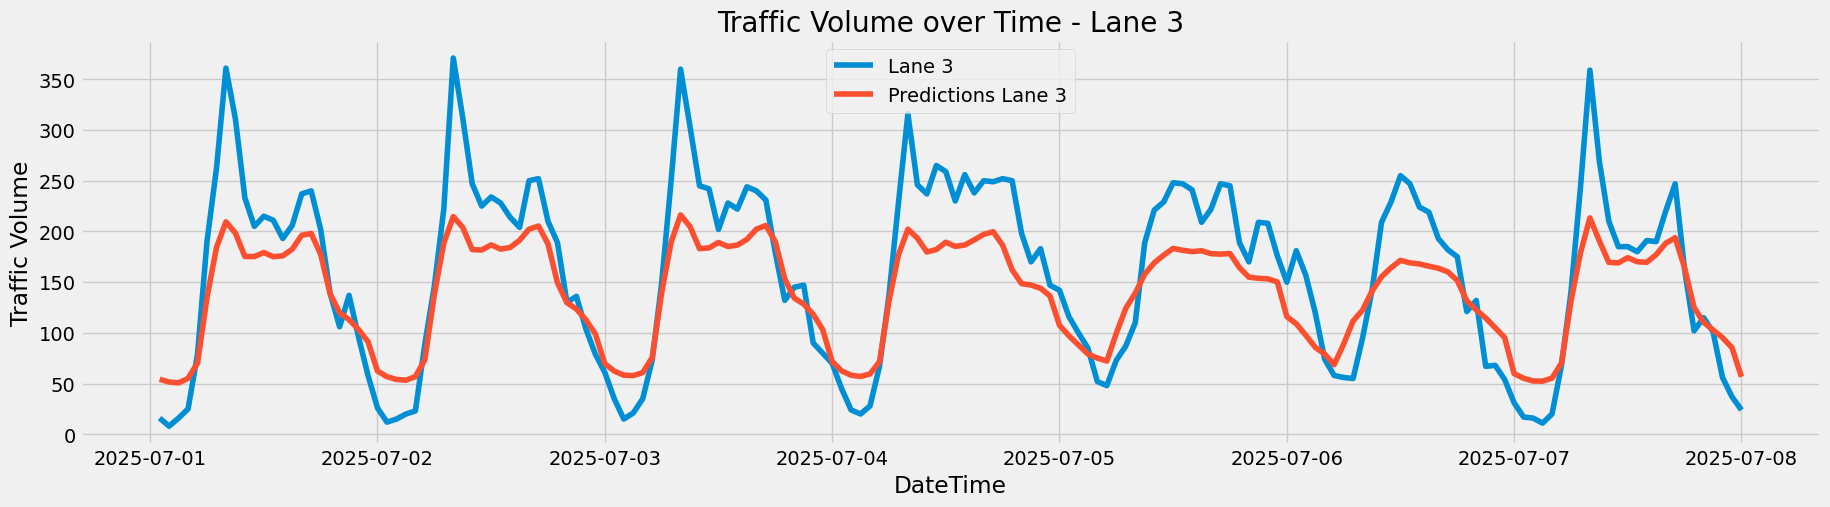

In [43]:
showTrafficVolumeWithPredictions(trydf,2052,3)

In [31]:
average_traffic = pd.DataFrame()
average_traffic['average_volume'] = trydf.groupby(trydf.index).mean()['Volume']
average_traffic['average_prediction'] =trydf.groupby(trydf.index).mean()['prediction']

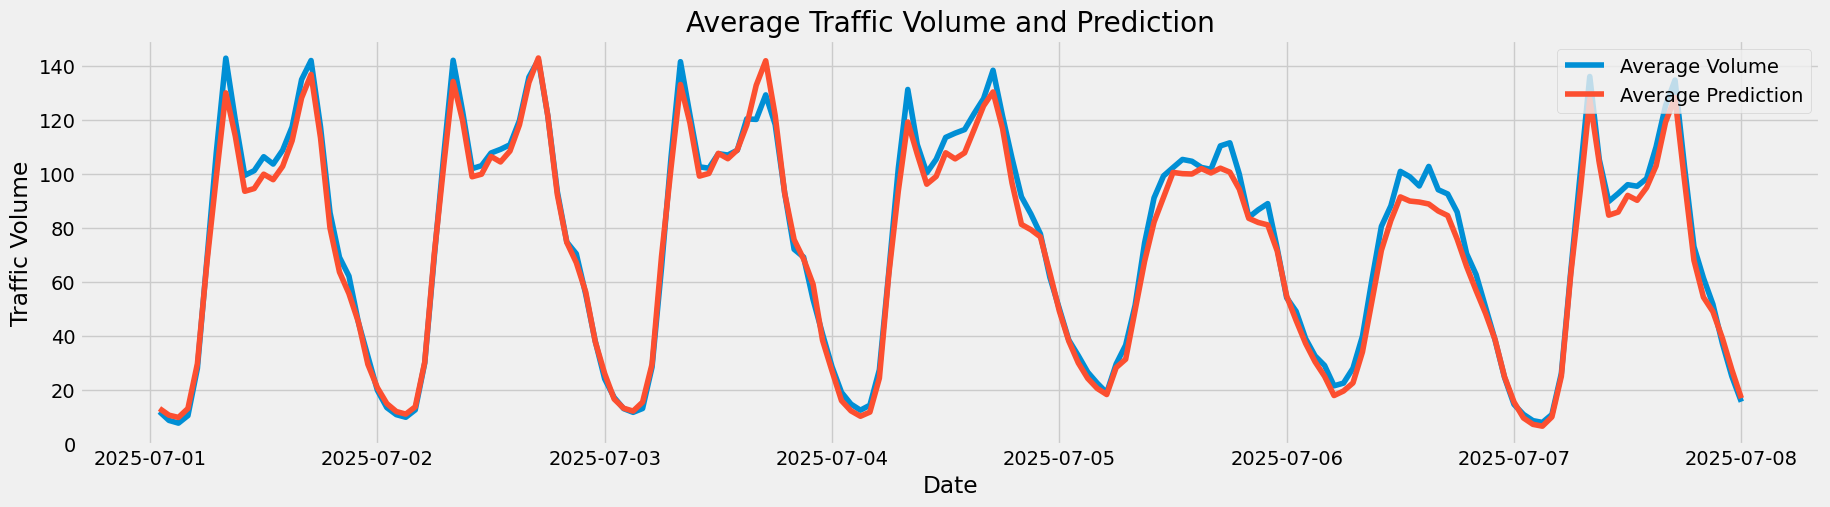

In [33]:
temp = average_traffic[(average_traffic.index > '2025-07-01') & (average_traffic.index <= '2025-07-08')] 
plt.figure(figsize=(20, 5))
plt.plot(temp.index, temp['average_volume'], label='Average Volume')
plt.plot(temp.index, temp['average_prediction'], label='Average Prediction')
plt.title('Average Traffic Volume and Prediction')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()

In [34]:
import shap
import tqdm as notebook_tqdm

C:\Users\hanju\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
background = X_train.sample(min(1000, len(X_train)), random_state=42)

explainer = shap.TreeExplainer(reg, feature_perturbation="tree_path_dependent")

In [36]:
# choose a set to explain
X_explain = X_test  # or X_test

# for speed on big sets, sample
X_explain_sample = X_explain.sample(min(5000, len(X_explain)), random_state=42)

# SHAP values: returns array (n_samples, n_features)
shap_values = explainer.shap_values(X_explain_sample)
# Expected value (model base value)
base_value = explainer.expected_value


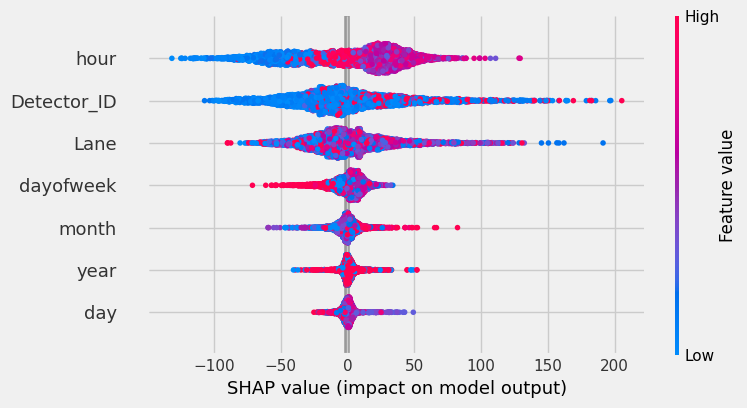

In [37]:
shap.summary_plot(shap_values, X_explain_sample, show=True)

In [33]:
X_explain[X_explain['Lane'] == 5].iloc[[8]]

,Detector_ID,Lane,hour,day,dayofweek,month,year
DateTime,,,,,,,
2024-10-01 08:00:00,2052,5,8,1,1,10,2024


In [34]:
test[test['Lane'] == 5].iloc[[0]]

,Detector_ID,Lane,Volume,hour,day,dayofweek,month,year,prediction
DateTime,,,,,,,,,
2024-10-01,2052,5,30,0,1,1,10,2024,40.659958


In [35]:
test[test['Lane'] == 6].iloc[[7272]]

,Detector_ID,Lane,Volume,hour,day,dayofweek,month,year,prediction
DateTime,,,,,,,,,
2025-07-31,2052,6,9,0,31,3,7,2025,12.788649


In [36]:
test[(test['Lane'] == 6) & (test.index == '2025-07-04 00:00:00')]

,Detector_ID,Lane,Volume,hour,day,dayofweek,month,year,prediction
DateTime,,,,,,,,,
2025-07-04,2052,6,5,0,4,4,7,2025,20.659849


In [37]:
test[(test['Lane'] == 6) & (test.index == '2025-07-04 08:00:00')]

,Detector_ID,Lane,Volume,hour,day,dayofweek,month,year,prediction
DateTime,,,,,,,,,
2025-07-04 08:00:00,2052,6,68,8,4,4,7,2025,80.808136


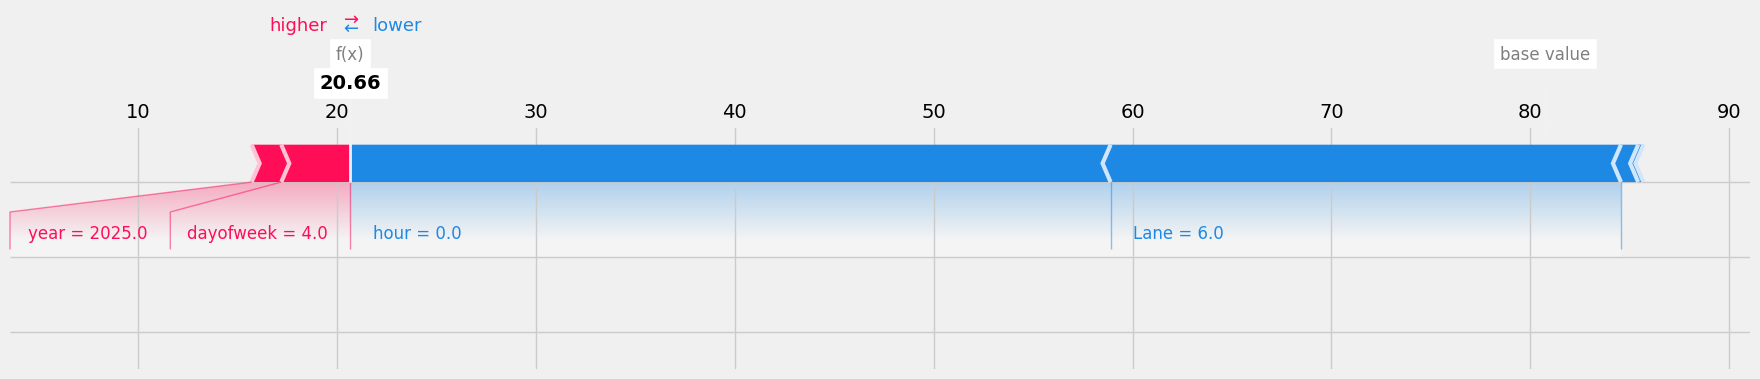

In [38]:
row = X_explain[(X_explain['Lane'] == 6) & (X_explain.index == '2025-07-04 00:00:00')]  # replace with your specific row selection

sv_row = explainer.shap_values(row)
shap.force_plot(base_value, sv_row, row, matplotlib=True)  # inline plot
plt.show()

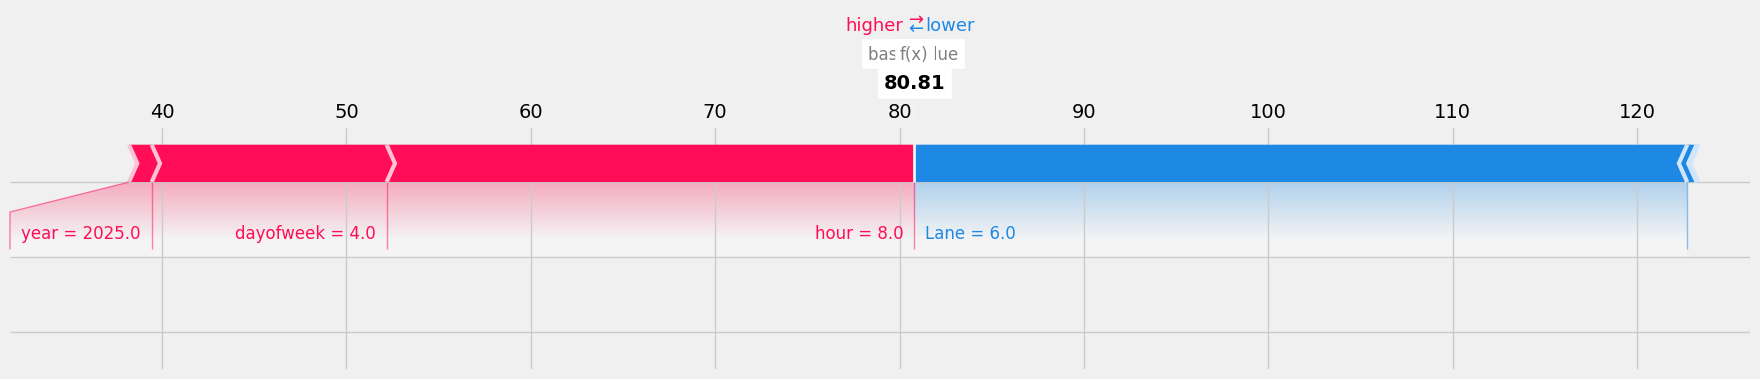

In [39]:
row = X_explain[(X_explain['Lane'] == 6) & (X_explain.index == '2025-07-04 08:00:00')]  # replace with your specific row selection

sv_row = explainer.shap_values(row)
shap.force_plot(base_value, sv_row, row, matplotlib=True)  # inline plot
plt.show()

In [320]:
print("Base value:", explainer.expected_value)

Base value: 137.98303


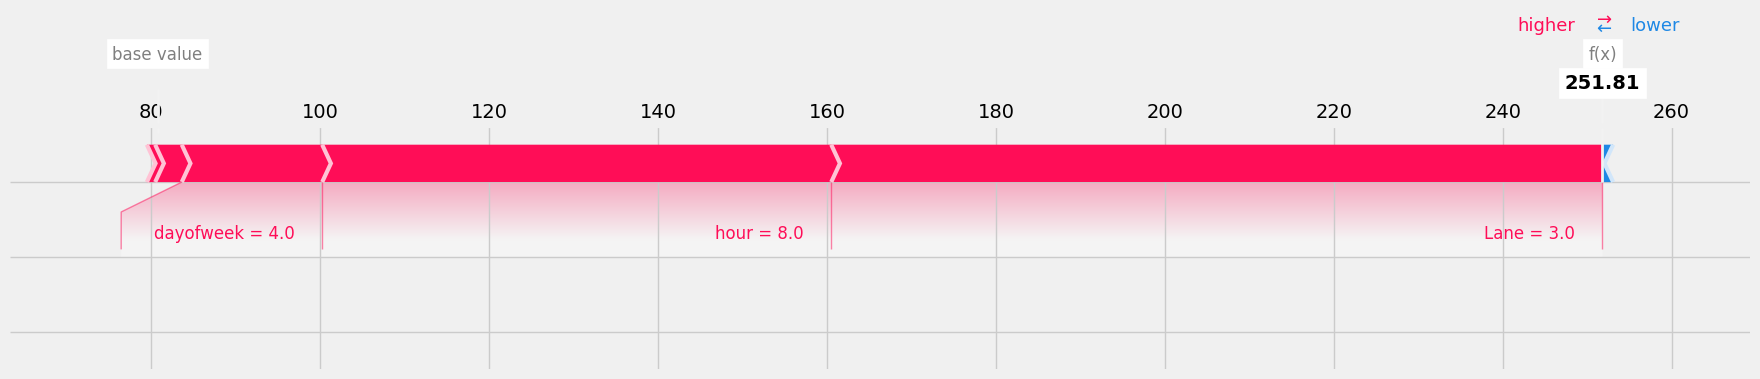

In [50]:
row = X_explain[(X_explain['Lane'] == 3) & (X_explain.index == '2025-07-04 08:00:00')]  # replace with your specific row selection

sv_row = explainer.shap_values(row)
shap.force_plot(base_value, sv_row, row, matplotlib=True)  # inline plot
plt.show()

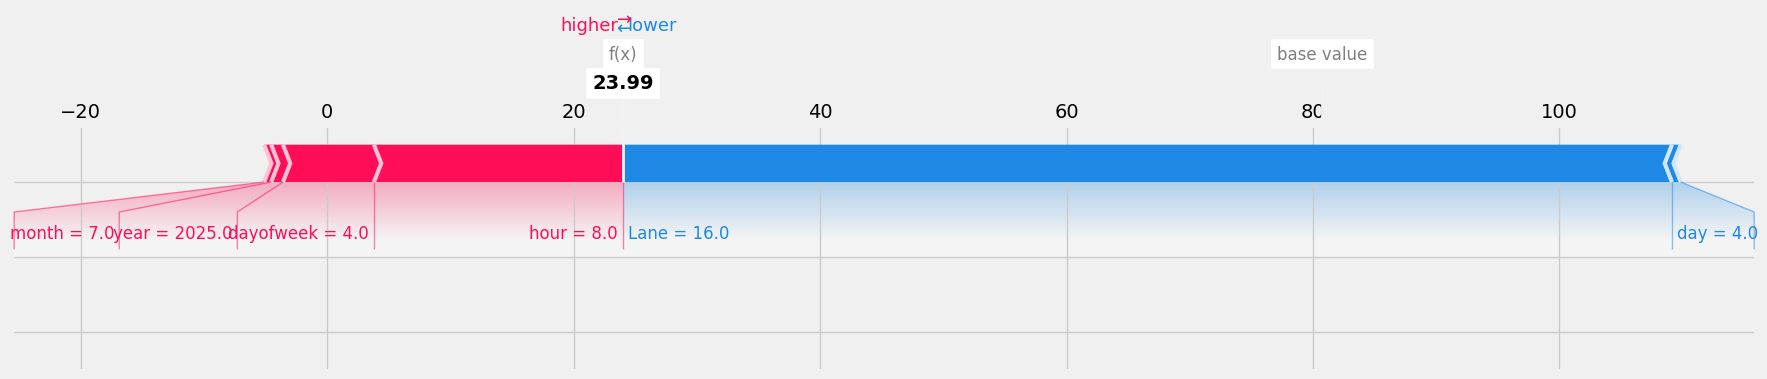

In [45]:
row = X_explain[(X_explain['Lane'] == 16) & (X_explain.index == '2025-07-04 08:00:00')]  # replace with your specific row selection

sv_row = explainer.shap_values(row)
shap.force_plot(base_value, sv_row, row, matplotlib=True)  # inline plot
plt.show()

In [59]:
test[(test['Lane'] == 3) & (test.index == '2025-07-04 08:00:00')]

,Detector_ID,Lane,Volume,hour,day,dayofweek,month,year,prediction
DateTime,,,,,,,,,
2025-07-04 08:00:00,2052,3,316,8,4,4,7,2025,251.813461


In [60]:
test[(test['Lane'] == 16) & (test.index == '2025-07-04 08:00:00')]

,Detector_ID,Lane,Volume,hour,day,dayofweek,month,year,prediction
DateTime,,,,,,,,,
2025-07-04 08:00:00,2052,16,15,8,4,4,7,2025,23.993311


In [321]:
test['prediction'].mean()

np.float32(132.75108)